# Diagnosing Breast Cancer: A comparison between Deep Learning + Machine Learning approaches

### Approach
In this notebook, I attempted to preprocess the breast cancer dataset and predict whether a patient has a cancerous or non-cancerous tumor. I attempt various methods, including Machine Learning and Deep Learning, and I utilize Randomized Grid Search to attempt to find the optimal parameters of the best performing models.

### Summary
The top performing model for me was a Random Forest model (outperforming Deep Learning), which was approximately 96.5% accurate on both the cross-validation sets, and the test set.

### Dataset
<p>The Wisconsin Breast Cancer data ids a dataset available on the UCI Machine Learning repository. Its features were computed using a digitized image of a fine needle aspirate (FNA) of a breast mass</p>

<p>The target variable is a binary classification, where 1 = Malignant (cancerous) and 0 = Benign (non-cancerous)</p>

<p>Features are included below</p>
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

 <p>Source Data: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29</p>

In [110]:
# Importing the data from scikit-learn
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

# Split into features and target
X = data.data
y = data.target

# Print shape of the data - we have only 569 rows, and 30 features
print(X.shape)
print(y.shape)

(569, 30)
(569,)


In [111]:
# Print feature names - 30 features describing the image of the tumor
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [112]:
# Print first 50 labels - looks like the target has already been encoded into 0 and 1
print(y[0:50])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1]


In [114]:
# Get distribution of count of 0's vs. 1's in the y array
count_0 = 0
count_1 = 0
for i in y:
    if i == 0:
        count_0 += 1
    else:
        count_1 += 1

# Balanced enough dataset to proress
print(f"Count of 0 (Benign): {count_0}")
print(f"Count of 1 (Malignant): {count_1}")

Count of 0 (Benign): 212
Count of 1 (Malignant): 357


In [196]:
# Import train/test split from scikit-learn
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing (using 80% for training, 20% for testing)
# Important to do this step before visualizing the data, so that we have no visibility into the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm size of training and test sets
print(len(X_train))
print(len(X_test))

455
114


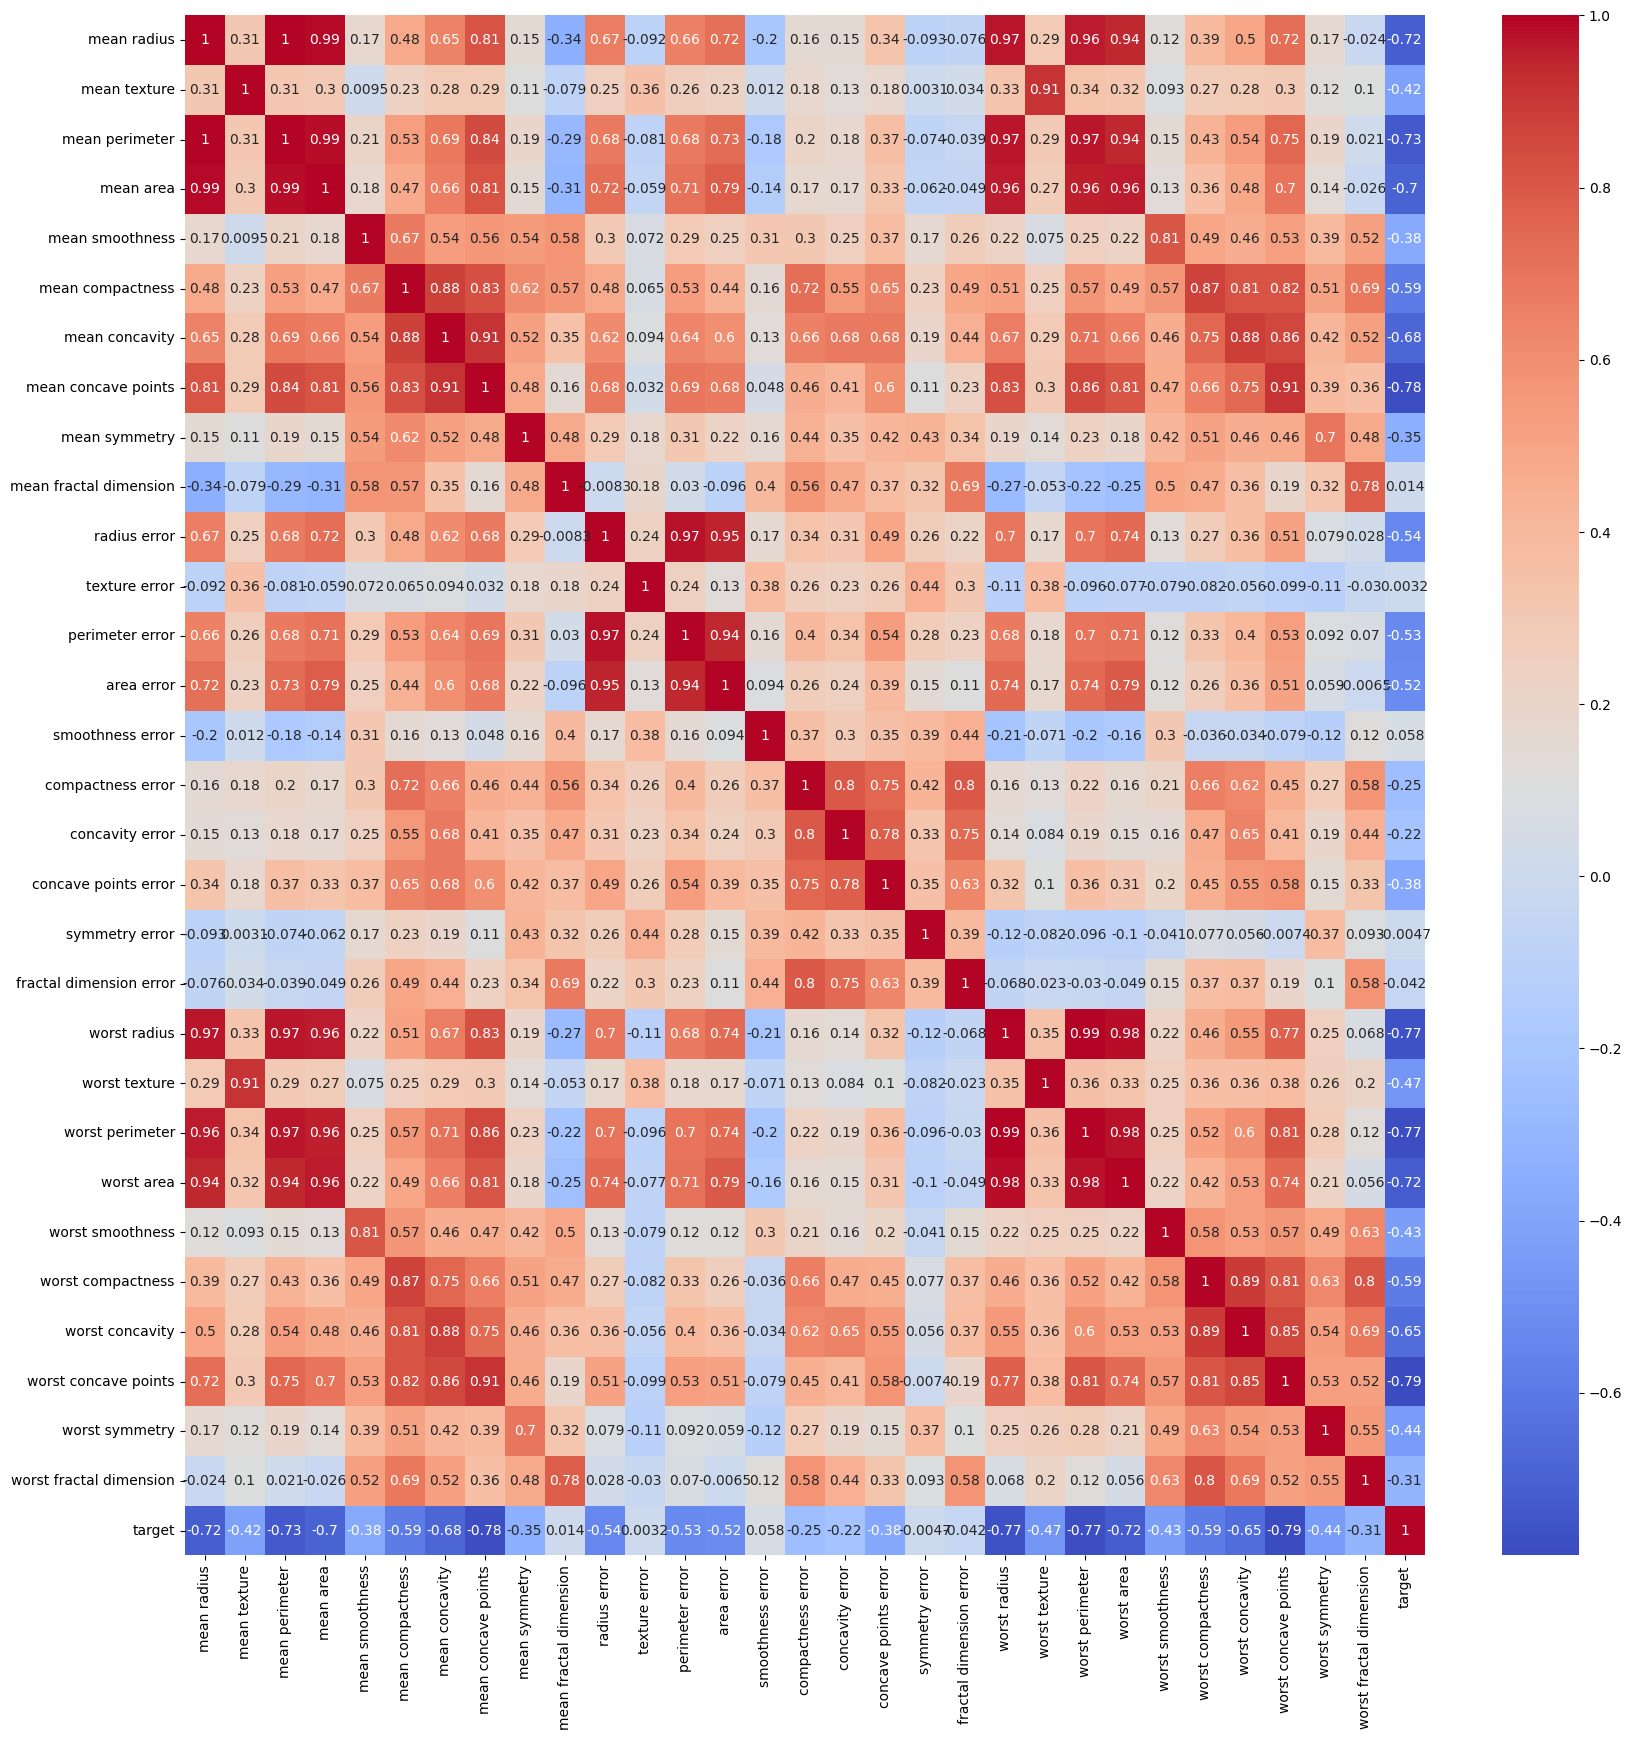

In [198]:
import seaborn as sns
import pandas as pd

# Create a Pandas dataframe from the X_train
df = pd.DataFrame(X_train, columns=data.feature_names)
df['target'] = y_train

# Create a correlation matrix heatmap using seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()



In [129]:
# Looks like we have some heavily correlated features (mean radius, mean perimeter, mean, area, worst radius, worst perimter, worst area)
# Removing all of those variables except for mean radius

# Collect indices of columns to delete
columns_to_delete = [i for i, feature_name in enumerate(data.feature_names) if feature_name in ['mean perimeter', 'mean area', 'worst radius', 'worst perimeter', 'worst area']]

# Delete columns from X_train and X_test by creating new arrays without the unwanted columns
X_train = np.delete(X_train, columns_to_delete, axis=1)
X_test = np.delete(X_test, columns_to_delete, axis=1)



In [130]:
# Remove the columns from the dataframe
print(X_train.shape)
print(X_test.shape)

(455, 25)
(114, 25)


In [131]:
# Scaling the features to have zero mean and unit variance
scaler = StandardScaler()

# Fit the scaler on the training dataset
scaler.fit(X_train)

# Transform both train and test datasets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
# Training first batch of ML models, using cross validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print("Logistic Regression Accuracy:", scores.mean())
# Random Forest
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Random Forest Accuracy:", scores.mean())

# Decision Tree
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
print("Decision Tree Accuracy:", scores.mean())

# Initial view suggests logistic regression and SVM are the same

Logistic Regression Accuracy: 0.9714285714285715
Random Forest Accuracy: 0.945054945054945
Decision Tree Accuracy: 0.9164835164835166


In [134]:
# Tuning Random Forest
rf = RandomForestClassifier()

param_grid = {
    'criterion': ["gini"], # default
    'max_features': ['sqrt'], #default, sqrt of n_features
    'bootstrap': [True], # default, bootstrap samples used when building trees (not whole dataset)
    'n_estimators': [300, 400, 500], # Number of trees in the forest
    'max_depth': [10], # Maximum depth of the tree
    'min_samples_split': [2], # Minimum number of samples required to split an internal node, default = 2
    'min_samples_leaf': [2] # Minimum samples on a a leaf node, default = 1
    # max_features (did not use, since we have a )
}

rf_grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', verbose=3)
rf_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.923 total time=   0.6s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.923 total time=   0.7s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.978 total time=   0.7s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.956 total time=   0.6s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.967 total time=   0.7s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2], 'min_samples_split': [2],
                         'n_estimators': [300, 400, 500]},
             scoring='accuracy', verbose=3)

In [136]:
print("Best parameters: ", rf_grid_search.best_params_)
print("Best score: ", rf_grid_search.best_score_)

# Use best model in rf_grid_search
rf_best = rf_grid_search.best_estimator_
print(rf_best)

Best parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best score:  0.9494505494505494
RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=300)


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning


# Tuning Logistic Regression
log_reg = LogisticRegression()

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], # Types of regularization
    'C': [0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'], # Optimization algorithms; note that 'saga' supports elasticnet
    'class_weight': [None, 'balanced'], # Option to handle imbalanced classes
    'max_iter': [100, 200, 300] # Maximum number of iterations for the solver to converge
}

# Note: Not all solvers support all penalty types. For example:
# - 'liblinear' supports 'l1' and 'l2'
# - 'lbfgs' supports 'l2' and 'none'
# - 'saga' supports 'l1', 'l2', 'elasticnet', and 'none'

# Initialize GridSearchCV, verbose = 0 since this leads to 1800 models being fit
log_reg_grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=0)

# Fit model
log_reg_grid_search.fit(X_train, y_train)

In [152]:
# After fitting, you can check the best parameters and the best score
print("Best parameters:", log_reg_grid_search.best_params_)
print("Best accuracy:", log_reg_grid_search.best_score_)

# Using that model
log_reg_best = log_reg_grid_search.best_estimator_
print(log_reg_best)

# Not bad! 97.8% accuracy with the best parameters

Best parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'penalty': 'none', 'solver': 'saga'}
Best accuracy: 0.9780219780219781
LogisticRegression(C=0.01, penalty='none', solver='saga')


In [144]:
# Moving onto Deep Learning
# Starting with a simple model before grid search
import tensorflow as tf
from tensorflow import keras

simple_model = keras.Sequential([
    keras.layers.Dense(25, input_shape=(25,), activation='relu'),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer="glorot_uniform")
])

# Configure the model for training on binary classification problem
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

simple_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)



Epoch 1/20
57/57 [==============================] - 1s 1ms/step - loss: 0.4550 - accuracy: 0.8286
Epoch 2/20
57/57 [==============================] - 0s 1ms/step - loss: 0.2759 - accuracy: 0.9121
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9253
Epoch 4/20
57/57 [==============================] - 0s 1ms/step - loss: 0.1663 - accuracy: 0.9495
Epoch 5/20
57/57 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.9648
Epoch 6/20
57/57 [==============================] - 0s 1ms/step - loss: 0.1194 - accuracy: 0.9692
Epoch 7/20
57/57 [==============================] - 0s 1ms/step - loss: 0.1058 - accuracy: 0.9802
Epoch 8/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9780
Epoch 9/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.9802
Epoch 10/20
57/57 [==============================] - 0s 1ms/step - loss: 0.0800 - accuracy: 0.9824
Epoch 11/20
57/57 [

In [145]:
# Optimizing neural network using grid search
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

def create_model(optimizer='adam', activation='relu', neurons=25, l2_reg=0.01, num_layers=2):
    model = Sequential()
    # Add the first layer separately to set the input shape
    model.add(Dense(neurons, input_shape=(25,), activation=activation, kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    
    # Now add additional layers based on num_layers
    for _ in range(num_layers - 1):  # Subtract 1 because we already added the first layer
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
    
    # Add the output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer="glorot_uniform"))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [146]:

# Wrapping as a scikit-learn model
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

In [148]:
# Setting up the parameter grid for the Neural Network
param_grid = {
    'model__num_layers': [1, 2, 3],
    'model__l2_reg': [0, 0.01, 0.001],
    'model__neurons': [10, 25, 50],
    'model__activation': ['relu'],
    'optimizer': ['adam'],
    'batch_size': [8, 16],
    'epochs': [10, 20]
}

from sklearn.model_selection import RandomizedSearchCV

# Using randomized grid search, with 20 iterations (CV=5), meaning 100 fits of th emodel
nn_grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=5, scoring='accuracy', verbose=3, n_jobs=1)

# Fitting th emodel
nn_grid_result = nn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END batch_size=16, epochs=20, model__activation=relu, model__l2_reg=0, model__neurons=10, model__num_layers=2, optimizer=adam;, score=0.945 total time=   2.5s
[CV 2/5] END batch_size=16, epochs=20, model__activation=relu, model__l2_reg=0, model__neurons=10, model__num_layers=2, optimizer=adam;, score=0.956 total time=   2.5s
[CV 3/5] END batch_size=16, epochs=20, model__activation=relu, model__l2_reg=0, model__neurons=10, model__num_layers=2, optimizer=adam;, score=0.978 total time=   2.3s
[CV 4/5] END batch_size=16, epochs=20, model__activation=relu, model__l2_reg=0, model__neurons=10, model__num_layers=2, optimizer=adam;, score=0.967 total time=   3.4s
[CV 5/5] END batch_size=16, epochs=20, model__activation=relu, model__l2_reg=0, model__neurons=10, model__num_layers=2, optimizer=adam;, score=0.956 total time=   4.0s
[CV 1/5] END batch_size=8, epochs=10, model__activation=relu, model__l2_reg=0.01, model__neurons=2

In [156]:
print(f"Best Score: {nn_grid_result.best_score_} using {nn_grid_result.best_params_}")

# Choose the model with the best score in random_grid_result
nn_best = nn_grid_result.best_estimator_

Best Score: 0.9824175824175825 using {'optimizer': 'adam', 'model__num_layers': 1, 'model__neurons': 25, 'model__l2_reg': 0.001, 'model__activation': 'relu', 'epochs': 20, 'batch_size': 8}


## Testing on the test set
<p>Until this point, we have not looked at the test set - we've chosen the best model based on performance across cross-validation sets.</p>

<p>Let's see how the Random Forest, Logistic Regression, and Neural Networks perform</p>

In [194]:
print("Neural Network Accuracy: ",nn_best.score(X_test, y_test))
print("Logistic Regression Accuracy: ",log_reg_best.score(X_test, y_test))
print("Random Forest Accuracy: ",rf_best.score(X_test, y_test))

# Very similar performance! Looks like Logistic Regression outperformed both NN and RF though

Neural Network Accuracy:  0.9649122807017544
Logistic Regression Accuracy:  0.9824561403508771
Random Forest Accuracy:  0.956140350877193


-------------Neural Net--------------
Accuracy: 0.9649122807017544
Precision: 0.971830985915493
Recall: 0.971830985915493


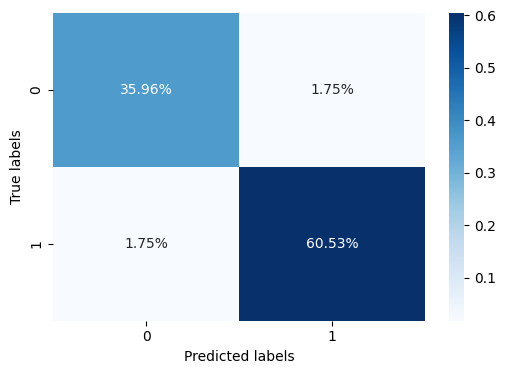

-------------RF--------------
Accuracy: 0.956140350877193
Precision: 0.9459459459459459
Recall: 0.9859154929577465


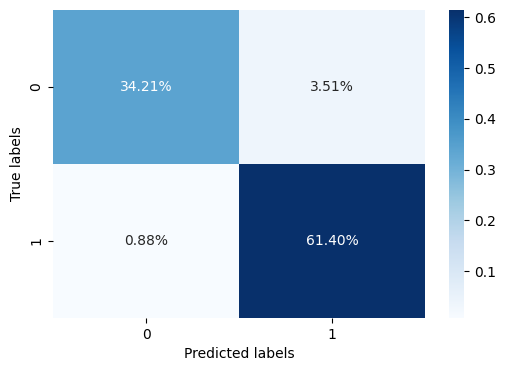

-------------Logistic--------------
Accuracy: 0.9824561403508771
Precision: 0.9859154929577465
Recall: 0.9859154929577465


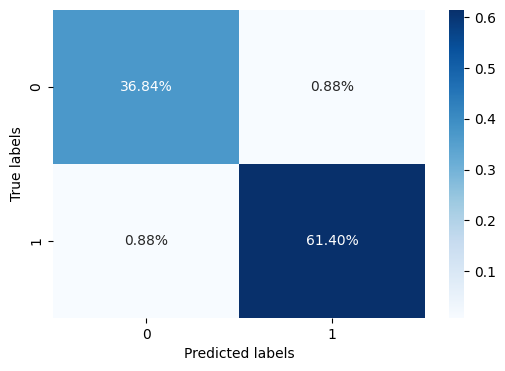

In [193]:
# Calculate accuracy, precision and show graphs
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Predict probability on the test set
def print_confusion_matrix(model, name):
    # Make predictions
    y_pred = model.predict(X_test)

    # Print name
    print(f"-------------{name}--------------")

    # Print accuracy, precision, and recall
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix / conf_matrix.sum(), annot=True
                , fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

print_confusion_matrix(nn_best, "Neural Net")
print_confusion_matrix(rf_best,"RF")
print_confusion_matrix(log_reg_best, "Logistic")

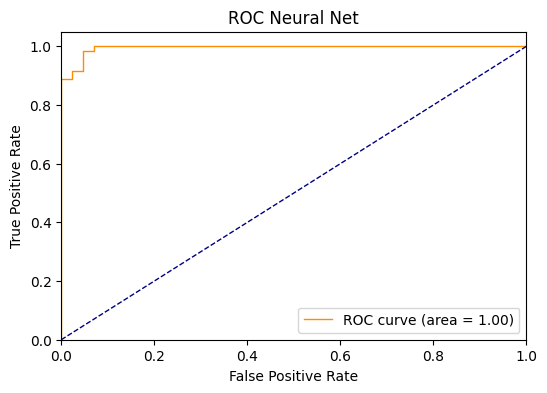

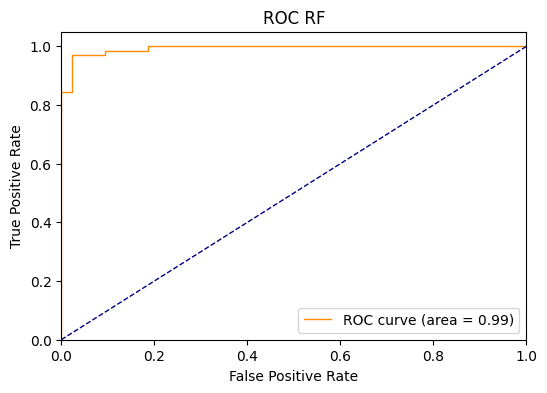

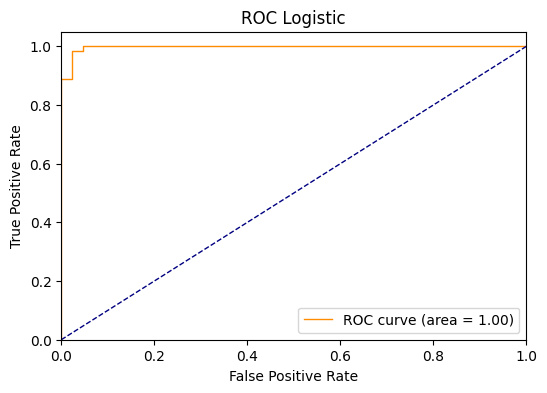

In [192]:
# Plot ROC
from sklearn.metrics import roc_curve, auc

# Create function to plot ROC, given an input model
def plot_roc(model, name):
    # Get probabilities of predictions
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC {name}')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(nn_best, "Neural Net")
plot_roc(rf_best,"RF")
plot_roc(log_reg_best, "Logistic")


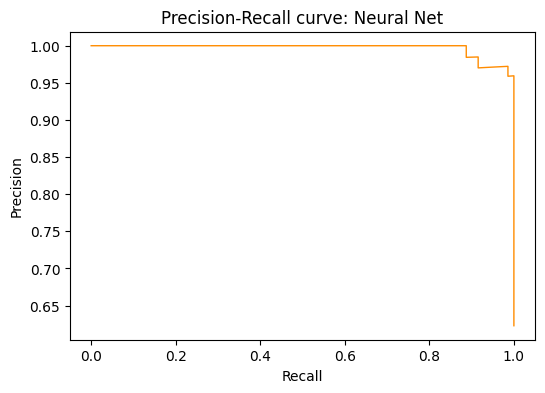

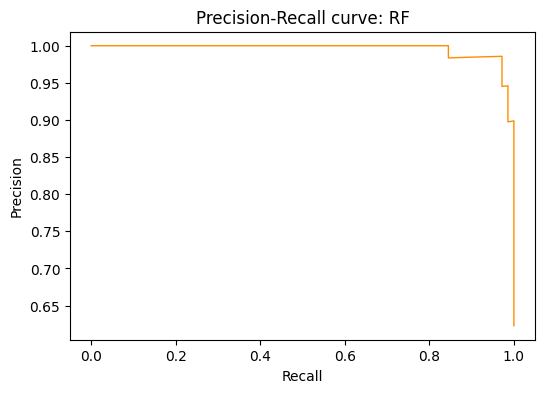

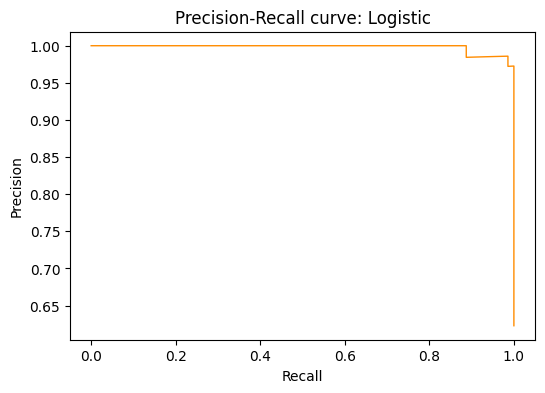

In [191]:
# Plot the precision recall tradeoff chart / f1 score
from sklearn.metrics import precision_recall_curve


# Create function to plot ROC, given an input model
def plot_precision_recall(model, name):
    # Get probabilities of predictions
    y_pred = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='darkorange', lw=1, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve: {name}')
    plt.show()

plot_precision_recall(nn_best, "Neural Net")
plot_precision_recall(rf_best, "RF")
plot_precision_recall(log_reg_best, "Logistic")